In [1]:
import pyabf
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from os import getcwd,listdir
import csv

# Function

## Version 2

In [28]:
def analysis_Bias(abf,volt,start_single,end_single,timeStart=0, timeEnd = None):
    abf.setSweep(0,channel=4)
    bias = np.digitize(abf.sweepY[timeStart:timeEnd],bins = [(volt-100)/2+100])
    close_index = []
    far_index = []
    index = []
    debug = False #When debugging, set debug to True

    # Solving starting with a single far point problem
    if start_single:
        close_flag = False
    else:
        close_flag = True
        
    for i in range(0,len(bias)-1):
        dif = bias[i+1]-bias[i]
        
        #只需考慮bias差值小於-1的部分（下降點）
        #另外應該從volt點下降，10是寬限，比方説800mv，則下降應從於700mv
        '''
        if dif<-1 and bias[i]>volt-95 and bias[i+1]<volt-95: 
            f = False
            for gap in range(5):
                if i+gap < len(bias):
                    if bias[i+gap]<volt-95:
                        f = True
                        break
            if f == False:
                break
            '''
        if dif == -1:
            index.append(i)
            if close_flag:
                close_index.append(i)
                close_flag = False
            else:
                far_index.append(i)
                close_flag = True
    
    # Solve starting and/or ending with a single far point problem
    if start_single:
        far_index = far_index[1:]
    if end_single:
        close_index = close_index[:-1]
    
    print("Close point found: "+str(len(close_index)))
    print("Far point found: "+str(len(far_index)))
    
    if debug:
        print("Close point are:")
        for i in close_index:
            print(abf.sweepX[timeStart:timeEnd][i],bias[i])

        print("Far point are:")
        for i in far_index:
            print(abf.sweepX[timeStart:timeEnd][i],bias[i])
    return index,close_index,far_index

In [29]:
def findStable_Bias(abf,volt,start_single=False,end_single=False,mean_range=5,timeStart = 0, timeEnd = None,channel = 2):
    index,close_index,far_index = analysis_Bias(abf,volt,start_single,end_single,timeStart = timeStart,timeEnd = timeEnd)
    
    # mean_range default set as 5 because 1ms = 5 data points
    abf.setSweep(0,channel=channel)
    close = []
    far = []

    for ci in close_index:
        t = abf.sweepY[timeStart:timeEnd][ci-4:ci+1]
        mean = np.mean(np.array(t))
        close.append(mean)
        
    for fi in far_index:
        t = abf.sweepY[timeStart:timeEnd][fi-4:fi+1]
        mean = np.mean(np.array(t))
        far.append(mean)
        
    return close,far,close_index,far_index

In [30]:
def print_points_qty(abf,index):
    x = []
    abf.setSweep(0,channel = 3)
    for c in index:
        x.append(abf.sweepY[c]) # Record X-axis value
    x = np.round(x,decimals = 0) # Round to bin
    newline = False
    lastx = -1
    C = []
    temp = []
    '''
    print("X:")
    X = []
    for e in x:
        if lastx != e:
            if e>lastx:
                temp.append(e)
            else:
                X.append(temp)
                temp = [e]
        lastx = e
    X.append(temp)
    for xx in X:
        print(xx)
    temp = []
    print("X end")
    '''
    # Count the record qty according to X-axis
    for e in x:
        if lastx != e:
            if e>lastx:
                temp.append(1)
            else:
                C.append(temp)
                temp = [1]
        else:
            temp[-1]+=1
        lastx = e
    C.append(temp)

    for t in C:
        for n in t:
            print("%-2d"%n,end=' ')
        print()
    print("Total points: "+str(np.sum(C)))

In [31]:
def plot_v2(abf,volt,start_single=False,end_single=False,timeStart = 0, timeEnd = None,channel = 2):
    abf.setSweep(0,channel = channel)
    plt.figure(figsize=(18,5))
    plt.plot(abf.sweepX[timeStart:timeEnd],abf.sweepY[timeStart:timeEnd],color = 'green')
    
    #plot the stable 
    index,close_index,far_index = analysis_Bias(abf,volt,start_single,end_single,timeStart = timeStart,timeEnd = timeEnd)
    abf.setSweep(0,channel = channel)
    barX_start = []
    barY_start = []
    barX_end = []
    barY_end = []
    counting = 0
    for i in index:
        length = 21
        counting+=1
        for j in range(length):
            barX_end.append(abf.sweepX[timeStart:timeEnd][i])
            barY_end.append(abf.sweepY[timeStart:timeEnd][i]+(j-int(length/2)+1))
            barX_start.append(abf.sweepX[timeStart:timeEnd][i-4])
            barY_start.append(abf.sweepY[timeStart:timeEnd][i-4]+(j-int(length/2)+1))
        plt.annotate(str(counting),xy=(abf.sweepX[timeStart:timeEnd][i-4],abf.sweepY[timeStart:timeEnd][i-4]+(j-int(length/2)+1)+1))
    plt.scatter(barX_end,barY_end,s=1,facecolors='b', edgecolors='b')
    plt.scatter(barX_start,barY_start,s=1,facecolors='r',edgecolors='r')
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.show()
    return len(close_index),len(far_index)

Close point found: 1
Far point found: 1


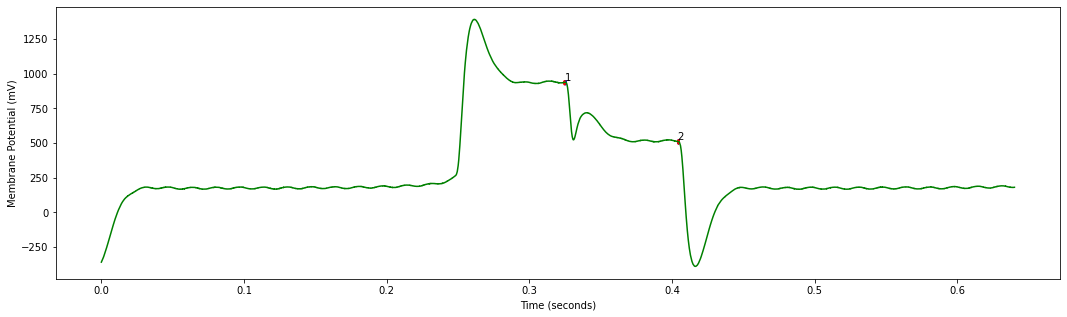

Close point found: 1
Far point found: 1


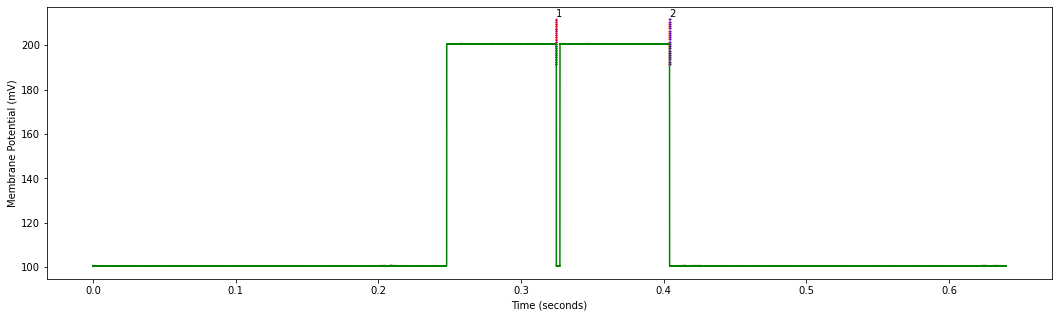

(1, 1)

In [32]:
#Test
abfFile = "22630007.abf"
volt = 200
abf = pyabf.ABF("abf\\"+abfFile)
plot_v2(abf,volt,timeStart = 0,timeEnd = 16000,channel=2)
plot_v2(abf,volt,timeStart = 0,timeEnd = 16000,channel=4)

## Version 1

In [33]:
# Separate AUT and Quartz
def separate(arr,Row=25,Col=100,pqty = 40,start_ignore = 4,end_ignore = 0,start_extra = 5,end_extra = 0,bias = 0):
    # start_ignore and end_ignore: extra points before reshape into rows
    # start_extra and end_extra: extra points of each rows
    # Convert end_ignore
    if end_ignore == 0:
        end_ignore = None
    else:
        end_ignore = -end_ignore
        
    # Convert end_extra
    if end_extra == 0:
        end_extra = None
        end_num = 0
    else:
        end_extra = -end_extra
        end_num = end_extra
    
    # Ignore first row
    print(6*Col + start_ignore,end_ignore)
    arr = arr[6*Col + start_ignore:end_ignore]
    arr = np.reshape(arr,(Row-1,Col+start_extra-end_num))
    aut = np.array([])
    quartz = np.array([])
    for row in arr:
        aut = np.append(aut,row[start_extra:start_extra+pqty])
        quartz = np.append(quartz,row[-pqty+end_num:end_extra])
    return aut+bias,quartz+bias

In [34]:
def plot_colormap(data,title = "AUT and QUARTZ",path = ""):
    """
    Helper function to plot data with associated colormap.
    """
   # fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=True, squeeze=False)
    figure, axes = plt.subplots(figsize=(data.shape[1]/5,data.shape[0]/5))
    psm = axes.pcolormesh(data, cmap='rainbow',rasterized=True)
    figure.colorbar(psm, ax=axes)
    axes.invert_yaxis()
    plt.title(title)
    plt.savefig(path+" "+title)
    plt.show()

# Test

## Test 01_v2 -- With start time and end time

Close point found: 0
Far point found: 0


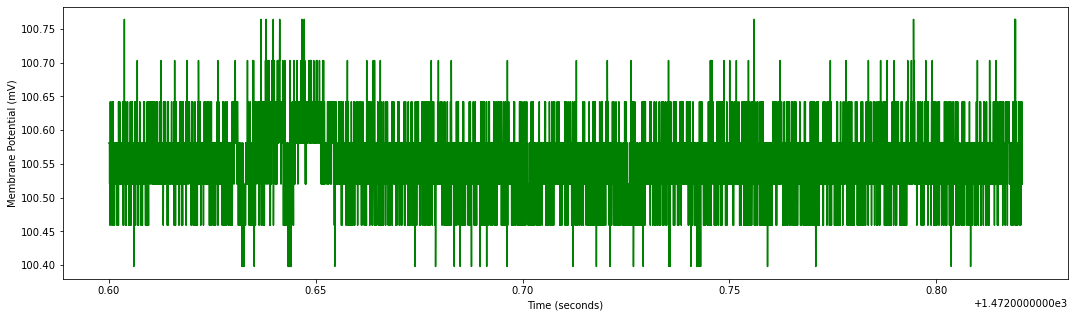

[100.5811 100.5811 100.5811 ... 100.52   100.6421 100.52  ]


In [35]:
timeStart = 36815000
timeEnd = 36820520
plot_v2(abf,volt,timeStart = timeStart, timeEnd = timeEnd,channel=4)
print(abf.sweepY[timeStart:timeEnd])

## Test 02_v2 -- Check all graph

Time: 0 ~ 200050
Close point found: 12
Far point found: 12


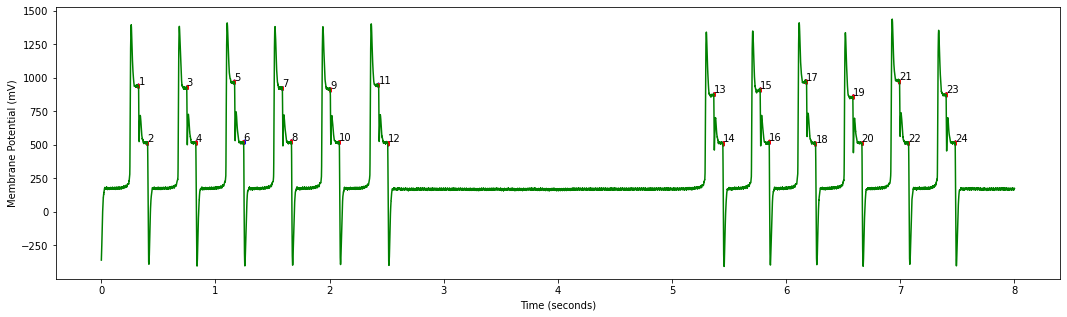

Time: 200000 ~ 400050
Close point found: 8
Far point found: 8


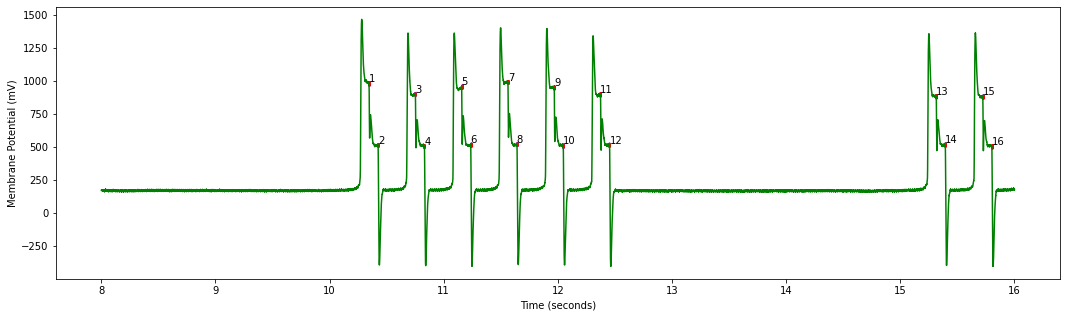

Time: 400000 ~ 600050
Close point found: 10
Far point found: 10


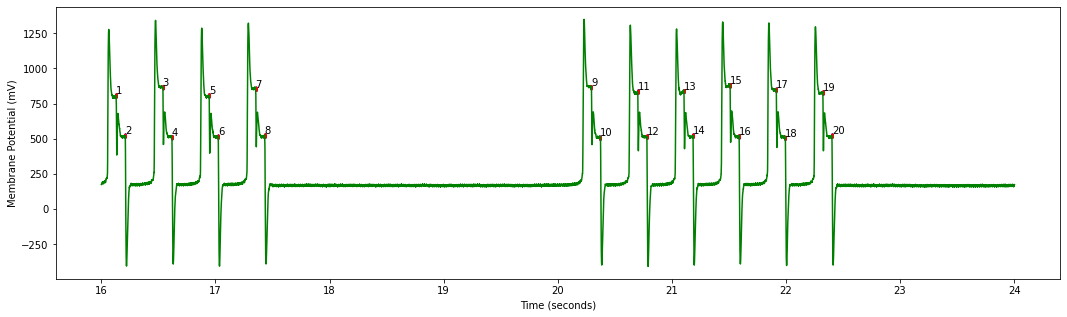

Time: 600000 ~ 800050


KeyboardInterrupt: 

<Figure size 1296x360 with 0 Axes>

In [36]:
interval = 200000
for i in range(0,len(abf.sweepY),interval):
    print("Time: %d ~ %d"%(i,i+interval+50))
    timeStart = i
    timeEnd = i+interval+50
    close_qty,far_qty = plot_v2(abf,volt,timeStart = timeStart, timeEnd = timeEnd,channel = 2)

## Test 03_v3--Check Total Points Collected in each (x,y)

In [37]:
print_points_qty(abf,end_index)

1  1  
Total points: 2


# Start

##### V2: Include Bias
* 800mV 22214004.abf: 3120 + 4(start) + 3(end) = 3127
* 700mV 22214005.abf: 3120 + 6(start) = 3126
* 200mV 22318006.abf: 3120 + 5(start) = 3125
* 500mV 22304010.abf:
* 200mV 22323007.abf: 3120 + 
* 200mV 22504024.abf: 3120 + 12(start) = 3132
* 600mV 22519010.abf: 3120 + 3(start)= 3123 #Care for time: 36818519 36818524
### V1: Not include Bias

* 800mV 21n05000.abf: 3120 + 4(start) = 3124
* 700mV 21n05001.abf: 3120 + 4(start) + 41(end) = 3165 
* 600mV 21n05002.abf: 3120 + 4(start) = 3124
* 500mV 21n05003.abf: 3120 + 6(start) + 21(end) = 3147
* 400mV 21n05004.abf: Last point have only close, 3120+5(start)+1(end) = 3126
* 300mV 21n05005.abf: 3120 + 4(start) + 39(end) = 3163
* 600mV 21930014.abf: 3120 + 5(start)  = 3125
* 800mV 21d04000.abf: 3120 + 6(start) + 30(end) =3156

In [38]:
# v2
abfFile = "22630007.abf"
abf = pyabf.ABF("abf\\"+abfFile)

In [39]:
bins = 50
start_ignore = 4 #Don't include the single point
end_ignore = 0  #Don't include the single point
pqty = 50
start_extra = 5
end_extra = 0
volt = 200 
title_prefix = str(volt)+"V"
fig_save_path =getcwd()+"\\result\\"
Row = 25
Col = 100
start_single = False
end_single = False
bias_emf = 0
bias_current = 0

In [40]:
close,far,close_index,end_index = findStable_Bias(abf,volt,start_single=start_single,end_single=end_single)

Close point found: 3126
Far point found: 3126


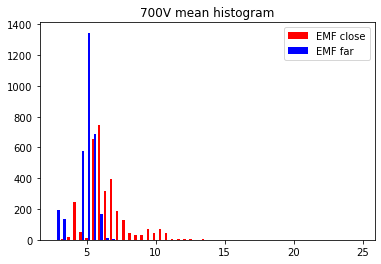

In [21]:
plt.figure()
plt.hist((close,far),bins=bins,label = ('EMF close','EMF far'),color = ('red','blue'))
plt.legend()
plt.title("%s mean histogram"%(title_prefix))
plt.savefig("%s mean histogram"%(title_prefix))
plt.show()

In [22]:
aut_close,quartz_close = separate(close,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra,bias = bias_emf)
aut_far,quartz_far = separate(far,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore,start_extra = start_extra, end_extra = end_extra,bias = bias_emf)

604 None
604 None


In [23]:
print("AUT Close:%.2f QUARTZ Close:%.2f"%(np.mean(aut_close),np.mean(quartz_close)))
print("AUT Far:%.2f QUARTZ Far:%.2f"%(np.mean(aut_far),np.mean(quartz_far)))

AUT Close:6.43 QUARTZ Close:6.28
AUT Far:5.14 QUARTZ Far:5.10


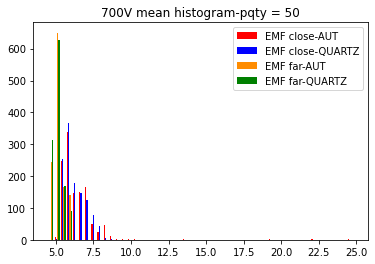

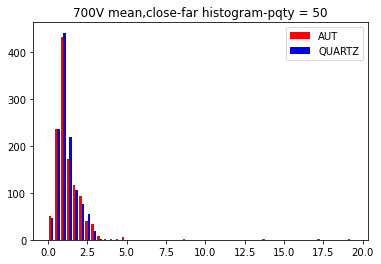

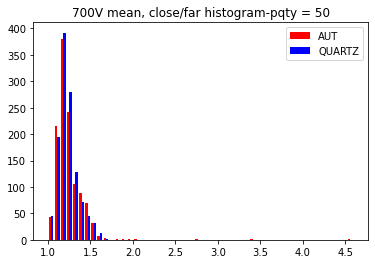

In [24]:
plt.figure()
plt.hist((aut_close,quartz_close,aut_far,quartz_far),bins=bins,label = ('EMF close-AUT','EMF close-QUARTZ','EMF far-AUT','EMF far-QUARTZ'),color = ('red','blue','darkorange','green'))
plt.legend()
plt.title("%s mean histogram-pqty = %d"%(title_prefix,pqty))
plt.savefig(fig_save_path+title_prefix+" mean histogram-pqty = "+str(pqty))
plt.show()

plt.figure()
plt.hist((aut_close-aut_far,quartz_close-quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title("%s mean,close-far histogram-pqty = %d"%(title_prefix,pqty))
plt.savefig(fig_save_path+title_prefix + " mean,close-far histogram-pqty = "+str(pqty))
plt.show()

plt.figure()
plt.hist((aut_close/aut_far,quartz_close/quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title("%s mean, close/far histogram-pqty = %d"%(title_prefix,pqty))
plt.savefig(fig_save_path+title_prefix + "close divide far histogram-pqty = "+str(pqty))
plt.show()

AUT: 1.249690 +- 3.347920
QUARTZ: 1.232682 +- 0.426301


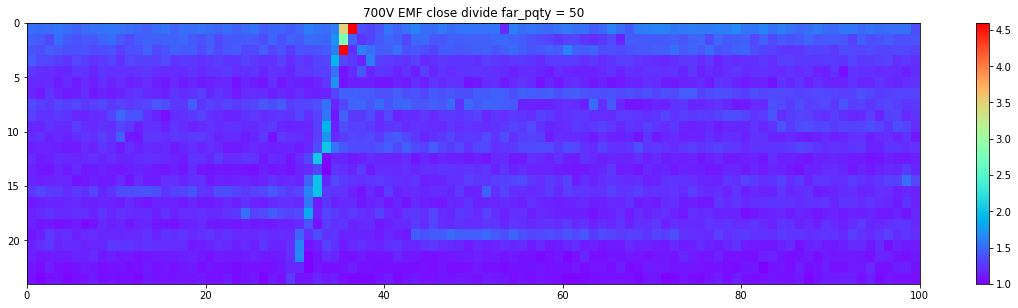

In [25]:
aut = aut_close/aut_far
quartz = quartz_close/quartz_far

a = aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

aut = np.reshape(aut,(24,pqty))
quartz = np.reshape(quartz,(24,pqty))

EMF_normalized_data = np.hstack((aut,quartz))
plot_colormap(EMF_normalized_data,title = title_prefix + " EMF close divide far_pqty = "+str(pqty),path = fig_save_path)

AUT: 1.287435 +- 18.121745
QUARTZ: 1.185354 +- 2.171580


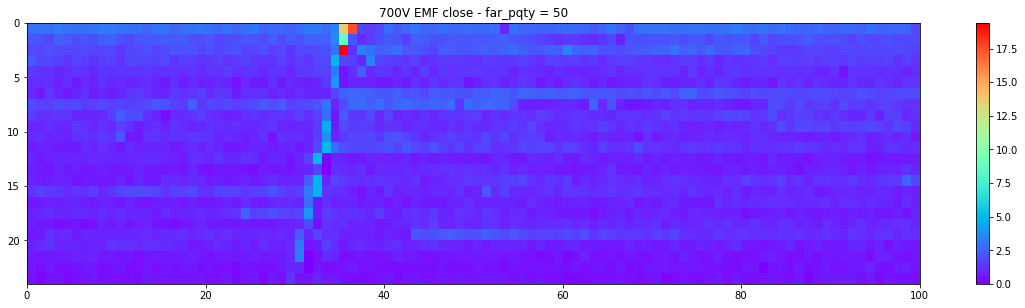

In [26]:
aut = aut_close-aut_far
quartz = quartz_close-quartz_far

a = aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

aut = np.reshape(aut,(24,pqty))
quartz = np.reshape(quartz,(24,pqty))

EMF_normalized_data_subs = np.hstack((aut,quartz))
plot_colormap(EMF_normalized_data_subs,title = title_prefix + " EMF close - far_pqty = "+str(pqty),path = fig_save_path)

In [34]:
# Calculate on Current
I_close,I_far,_,_ = findStable_Bias(abf,volt,start_single=start_single,end_single=end_single,channel = 0)

I_aut_close,I_quartz_close = separate(I_close,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra,bias = bias_current)
I_aut_far,I_quartz_far = separate(I_far,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra,bias = bias_current)

Close point found: 3124
Far point found: 3124
604 None
604 None


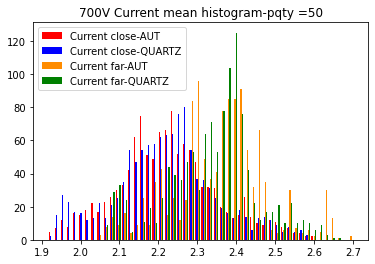

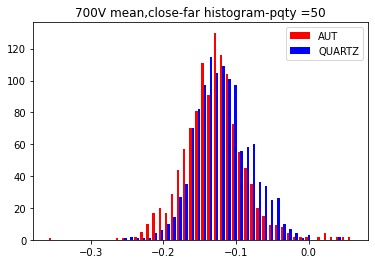

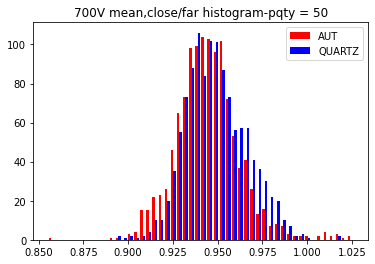

In [35]:
plt.figure()
plt.hist((I_aut_close,I_quartz_close,I_aut_far,I_quartz_far),bins=bins,label = ('Current close-AUT','Current close-QUARTZ','Current far-AUT','Current far-QUARTZ'),color = ('red','blue','darkorange','green'))
plt.legend()
plt.title(title_prefix + " Current mean histogram-pqty =" +str(pqty))
plt.savefig(fig_save_path+title_prefix + " Current mean histogram-pqty =" +str(pqty))
plt.show()

plt.figure()
plt.hist((I_aut_close-I_aut_far,I_quartz_close-I_quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " mean,close-far histogram-pqty =" +str(pqty))
plt.savefig(fig_save_path+title_prefix + " mean,Current close-far histogram-pqty =" +str(pqty))
plt.show()

plt.figure()
plt.hist((I_aut_close/I_aut_far,I_quartz_close/I_quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " mean,close/far histogram-pqty = "+str(pqty))
plt.savefig(fig_save_path+title_prefix + " mean,Current close divide far histogram-pqty =" +str(pqty))
plt.show()

In [36]:
I_aut = I_aut_close/I_aut_far
I_quartz = I_quartz_close/I_quartz_far

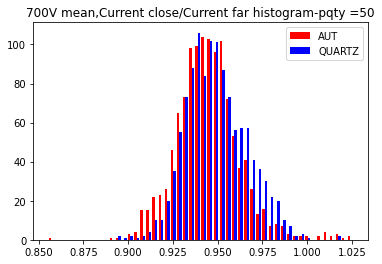

In [37]:
plt.figure()
plt.hist((I_aut,I_quartz),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " mean,Current close/Current far histogram-pqty =" +str(pqty))
plt.savefig(fig_save_path+title_prefix + " mean,Current close divide Current far histogram-pqty =" +str(pqty))
plt.show()

AUT: 0.944919 +- 0.089771
QUARTZ: 0.948996 +- 0.069088


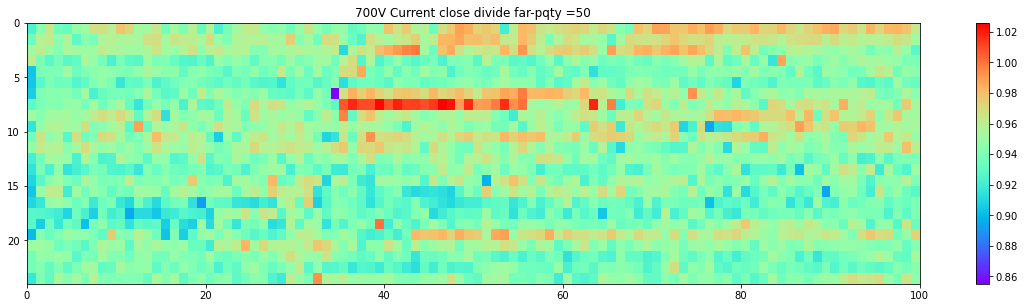

In [38]:
a = I_aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = I_quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

I_aut = np.reshape(I_aut,(24,pqty))
I_quartz = np.reshape(I_quartz,(24,pqty))

Current_normalized_data = np.hstack((I_aut,I_quartz))

plot_colormap(Current_normalized_data,title = title_prefix +  " Current close divide far-pqty =" +str(pqty),path = fig_save_path)

AUT: -0.129183 +- 0.230009
QUARTZ: -0.118401 +- 0.160576


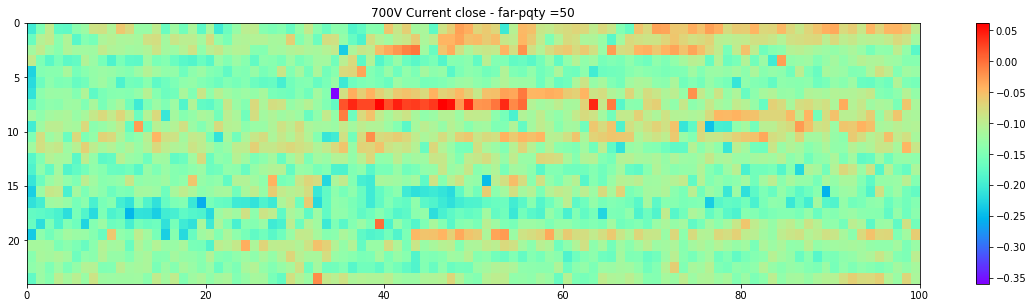

In [39]:
I_aut = I_aut_close-I_aut_far
I_quartz = I_quartz_close-I_quartz_far

a = I_aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = I_quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

I_aut = np.reshape(I_aut,(24,pqty))
I_quartz = np.reshape(I_quartz,(24,pqty))

Current_normalized_data_subs = np.hstack((I_aut,I_quartz))

plot_colormap(Current_normalized_data_subs,title = title_prefix +  " Current close - far-pqty =" +str(pqty),path = fig_save_path)


In [33]:
with open("result\\"+abfFile+'_current_div-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in Current_normalized_data:
        writer.writerow(row)

In [51]:
with open("result\\"+abfFile+'_current_subs-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in Current_normalized_data_subs:
        writer.writerow(row)

In [52]:
with open("result\\"+abfFile+'_EMF_div-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in EMF_normalized_data:
        writer.writerow(row)

In [53]:
with open("result\\"+abfFile+'_EMF_subs-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in EMF_normalized_data_subs:
        writer.writerow(row)

In [54]:
with open("result\\"+abfFile+'_EMF-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for w,x,y,z in zip(aut_close,aut_far,quartz_close,quartz_far):
        writer.writerow([w,x,y,z])

In [55]:
with open("result\\"+abfFile+'-pqty='+str(pqty)+'_current.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for w,x,y,z in zip(I_aut_close,I_aut_far,I_quartz_close,I_quartz_far):
        writer.writerow([w,x,y,z])